# Brain Tumor Detection with Convolutional Neural Networks

Adrian P. Bustamante, Ph.D.

adrianpebus@gmail.com

### __Table of Contents__

<ol>
    <li><a href="#1.-Objective">Objective</a></li>
    <li><a href="#2.-About-the-dataset">About the dataset</a></li>
    <li><a href="#3.-Data-Preparation">Data Preparation</a></li>
    <li><a href="#4.-Training-models">Training models</a></li>
    <ol>
        <li><a href="#A.-Customed-CNN">Customed CNN</a></li>
        <li><a href="#B.-MobileNet" >Content based Course Recommender System using Course Similarities</a></li>
    </ol>
    <li><a href="#5.-Conclusion">Conclusion</a></li>
</ol>

## 1. Objective

We work with a dataset containing MRI scans divided into four classes, three tumor classes (Pituitary, Glioma, and Meningiome) and one class representing normal brain scans. The aim of this notebook is to use Convolutional Neural Networks (CNN) to distinguish between normal brain scans and those containing any of the tumor classes. To achieve this goal we build, and tune, a deep CNN and we also use a pretrained convolutional network (Mobilnet).

## 2. About the dataset

**What is a brain tumor?**

A brain tumor is a collection, or mass, of abnormal cells in your brain. Your skull, which encloses your brain, is very rigid, and any growth inside such a restricted space can cause problems. Brain tumors can be cancerous (malignant) or noncancerous (benign). When benign or malignant tumors grow, they can cause the pressure inside your skull to increase, this can cause brain damage, and it can be life-threatening. Early detection and classification of brain tumors is an important research domain in the field of medical imaging and accordingly helps in selecting the most convenient treatment method to save patients life. The application of deep learning approaches in context to improve health diagnosis is providing impactful solutions. According to the World Health Organization (WHO), proper brain tumor diagnosis involves detection, brain tumor location identification, and classification of the tumor on the basis of malignancy, grade, and type.

**Dataset**

The dataset considered here consists of four classes, including three tumor classes (Pituitary, Glioma and Meningioma) and one class representing normal brain MRI scans. To enhance the diversity and robustness of the dataset, various image augmentation techniques were used. These techniques were applied to the images without altering the labels. Here is a summary of the augmentation methods used:

Salt and Pepper Noise: Introducing random noise by setting pixels to white or black based on a specified intensity.\
Histogram Equalization: Applying histogram equalization to enhance the contrast and details in the images.\
Rotation: Rotating the images clockwise or counterclockwise by a specified angle.\
Brightness Adjustment: Modifying the brightness of the images by adding or subtracting intensity values.\
Horizontal and Vertical Flipping: Flipping the images horizontally or vertically to create mirror images.

The clean and augmented dataset can be found at: https://www.kaggle.com/datasets/mohammadhossein77/brain-tumors-dataset/data


##### import libraries

In [21]:
import os, shutil, random, pathlib
import tensorflow as tf 
import keras_tuner as kt
import numpy as np, matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten
#from keras.applications import VGG16
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
%matplotlib inline

# Set seed for reproducibility
seed_value = 666
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

#You may want to comment out these lines if you are using the GPU architechture
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

plt.style.use('dark_background')
tf.__version__

'2.19.0'

##### Downloading the data

In [27]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mohammadhossein77/brain-tumors-dataset")

#print("Path to dataset files:", path)


## 3. Data Preparation

##### Creating directories and moving the data

In [4]:
###creating train, test directories
dataset_home = os.path.join(path, 'Data/')
subdirs =['train/', 'test/']
for subdir in subdirs:
    labeldirs = ['no_tumor/', 'glioma/', 'meningioma/', 'pituitary/']
    for labeldir in labeldirs:
        newdir = dataset_home + subdir + labeldir
        os.makedirs(newdir, exist_ok=True)

In [5]:
###moving images to train, test directories
source_dirs = ['Normal/', 'Tumor/glioma_tumor/', 'Tumor/meningioma_tumor/', 'Tumor/pituitary_tumor'] 
sbudirs = [ 'train/', 'test/']
dest_dirs = ['no_tumor/', 'glioma/', 'meningioma/', 'pituitary/']

for subdir, destdir in zip(source_dirs, dest_dirs):
    source = dataset_home + subdir
    dest_train = dataset_home + 'train/' + destdir
    dest_test = dataset_home + 'test/' + destdir
    files = os.listdir(source)
    train_size = int(len(files)*0.7)
    train_files = random.sample(files, train_size)
    test_files = set(files).difference(train_files)
    for filename in train_files:
        shutil.move(join(source, filename), dest_train)
    for filename in test_files:
        shutil.move(join(source, filename), dest_test)

In [6]:
# Define directories for train, test, and validation splits
train_dir = os.path.join(dataset_home, 'train')
test_dir = os.path.join(dataset_home, 'test')

print('Training')
data_dir_train=pathlib.Path(train_dir)
for folder in data_dir_train.glob('*'):
    print(f'The folder {folder.name} has {len(list(folder.glob('*.jpg')))} pictures')
image_count = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count, 'total training images')


print('Testing')
data_dir_test=pathlib.Path(test_dir)
for folder in data_dir_test.glob('*'):
    print(f'The folder {folder.name} has {len(list(folder.glob('*.jpg')))} pictures')
image_count = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count, 'total test images')



Training
The folder pituitary has 4135 pictures
The folder glioma has 4414 pictures
The folder meningioma has 4473 pictures
The folder no_tumor has 2146 pictures
15168 total training images
Testing
The folder pituitary has 1773 pictures
The folder glioma has 1893 pictures
The folder meningioma has 1918 pictures
The folder no_tumor has 920 pictures
6504 total test images


##### Train, test, and validation sets

In [7]:
#Set the batch size,epochs
batch_size = 64
n_epochs = 50
n_epochs_tune = 5
###original size (224, 224, 3)
img_rows, img_cols = 128, 128
input_shape = (img_rows, img_cols, 3)

In [8]:
print('training/validation')
train_generator, validation_generator = tf.keras.utils.image_dataset_from_directory(
    directory=train_dir,
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(img_rows, img_cols),
    shuffle=True,
    seed=seed_value,
    validation_split=0.3,
    subset='both',
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
    pad_to_aspect_ratio=False,
    data_format=None,
    verbose=True,
)

print('testing')
test_generator = tf.keras.utils.image_dataset_from_directory(
    directory=test_dir,
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(img_rows, img_cols),
    shuffle=True,
    seed=seed_value,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
    pad_to_aspect_ratio=False,
    data_format=None,
    verbose=True,
)

training/validation
Found 15168 files belonging to 4 classes.
Using 10618 files for training.
Using 4550 files for validation.


2025-04-02 15:14:30.081299: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


testing
Found 6504 files belonging to 4 classes.


2025-04-02 16:47:26.211515: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


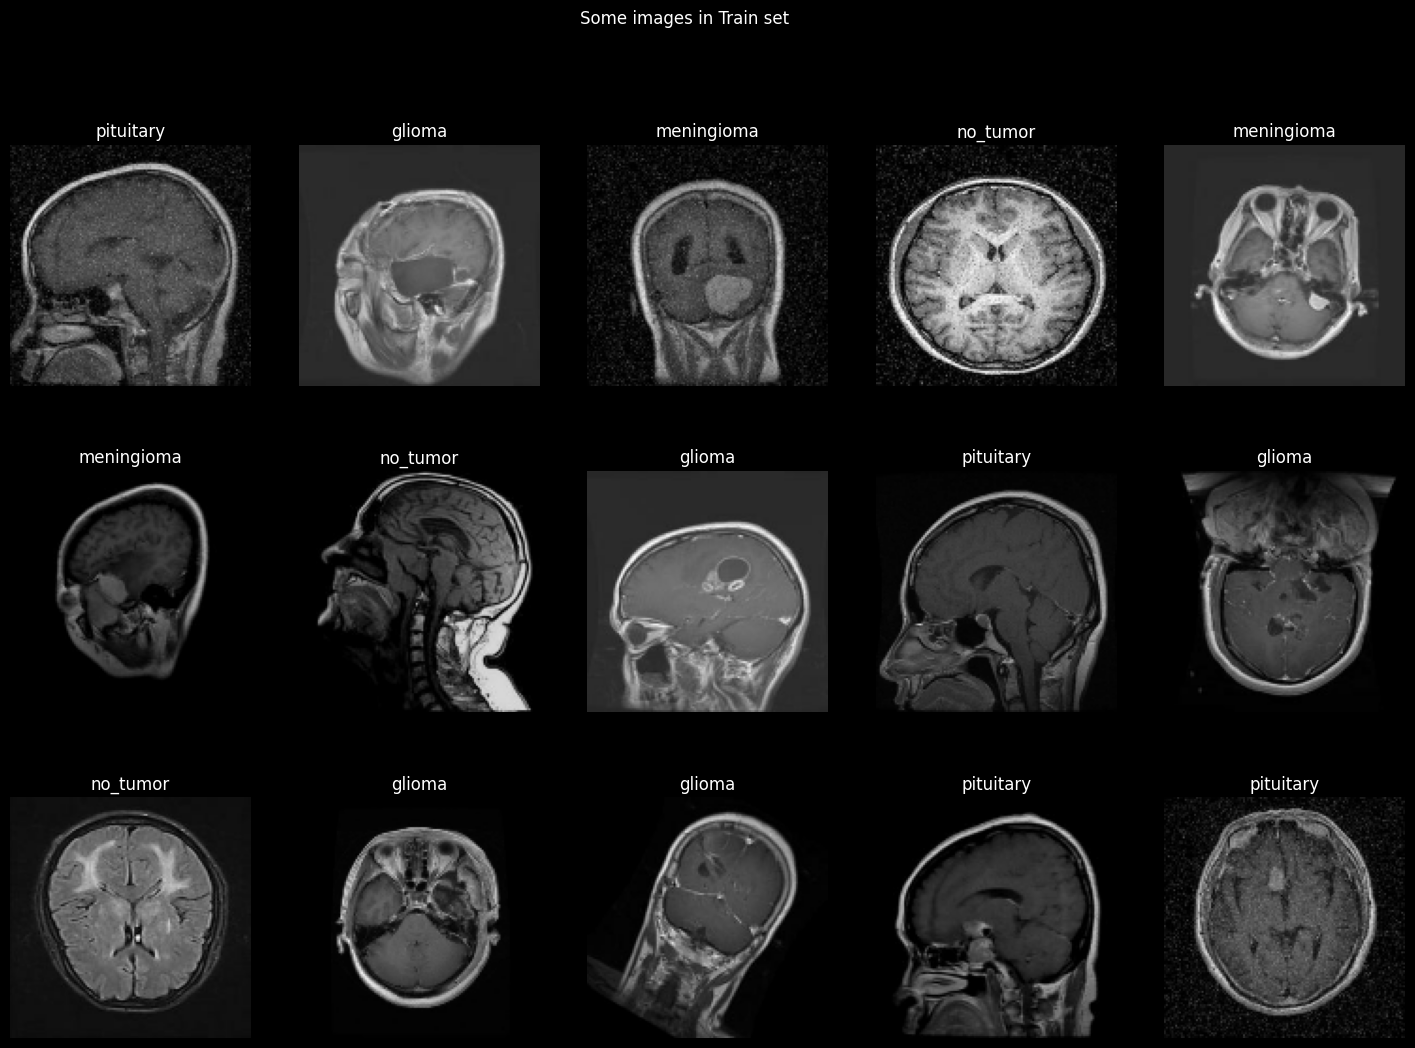

In [22]:
###visualizing some images in the train set

class_names = train_generator.class_names

first_batch = train_generator.take(1)
#tf.cast(my_tensor, tf.float32)
plt.figure(figsize=(18,12))
plt.suptitle('Some images in Train set')
for img, lbl in first_batch:
    for i in np.arange(15):
        plt.subplot(3,5, i+1)
        plt.imshow(img[i].numpy().astype('uint8'))
        #print(np.nonzero(lbl[i])[0][0])
        plt.title(class_names[np.nonzero(lbl[i])[0][0]])
        #plt.title(class_names[lbl[i].numpy().astype('int')])
        plt.axis('off')

## 4. Training models

### A. Customed CNN

#### Tuning the Network

In [10]:
def build_cnn(hp):
    cnn = Sequential()
    # Input tensor shap
    cnn.add(tf.keras.layers.Input(shape=input_shape))
    # Convolutional layer 1
    cnn.add(tf.keras.layers.Conv2D(64, (5, 5), activation="relu"))
    cnn.add(tf.keras.layers.MaxPooling2D(pool_size=(3, 3)))
    # Convolutional layer 2
    cnn.add(tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation="relu"))
    cnn.add(tf.keras.layers.MaxPooling2D(pool_size=(3, 3)))
    # Convolutional layer 3
    cnn.add(tf.keras.layers.Conv2D(128, (3, 3), activation="relu"))
    cnn.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    # Convolutional layer 4
    cnn.add(tf.keras.layers.Conv2D(128, (3, 3), padding='same',activation="relu"))
    cnn.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    cnn.add(tf.keras.layers.Flatten())
    # Dense layers 
    cnn.add(tf.keras.layers.Dense(512, activation="relu"))
    cnn.add(tf.keras.layers.Dropout(rate=hp.Choice('rate',[0.1,0.2,0.3])))
    cnn.add(tf.keras.layers.Dense(4, activation="softmax"))

    cnn.compile(optimizer=Adam(learning_rate = hp.Choice('learn_rate', values = [0.01, 0.001, 0.0001])),
                  loss='categorical_crossentropy',
                  metrics = ['accuracy', 'f1_score']
                 )
    return cnn

tuner_cnn = kt.RandomSearch(
    build_cnn,
    objective='val_accuracy',
    max_trials=9,
    max_retries_per_trial=3,
    max_consecutive_failed_trials=2,
    overwrite=False,
    project_name='bt_cnn')

tuner_cnn.search_space_summary()


Reloading Tuner from ./bt_cnn/tuner0.json
Search space summary
Default search space size: 2
rate (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.2, 0.3], 'ordered': True}
learn_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [11]:
#random search
early_stop=tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
tuner_cnn.search(train_generator, 
                 validation_data =validation_generator,
                 epochs=n_epochs_tune,
                 callbacks=[early_stop])
tuner_cnn.results_summary(num_trials=3)

Results summary
Results in ./bt_cnn
Showing 3 best trials
Objective(name="val_accuracy", direction="max")

Trial 0 summary
Hyperparameters:
rate: 0.2
learn_rate: 0.001
Score: 0.8799999952316284

Trial 5 summary
Hyperparameters:
rate: 0.1
learn_rate: 0.001
Score: 0.8789011240005493

Trial 3 summary
Hyperparameters:
rate: 0.3
learn_rate: 0.001
Score: 0.8512088060379028


#### Using Best Hyperparameters

In [12]:
best_hps=tuner_cnn.get_best_hyperparameters(num_trials=1)[0]
print('Best hyperparameters: ', best_hps.values)
best_cnn = build_cnn(best_hps)
best_cnn.summary()

checkpoint_path='bt_cnn_notune.keras'
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=6),
             tf.keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='loss', save_best_only=True, mode='min'),
             tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",factor=0.1,patience=3,verbose=1,mode="auto",
                                                  min_delta=0.001,cooldown=0,min_lr=0.0)
            ]

train_history = best_cnn.fit(train_generator, 
                             validation_data = validation_generator,
                             epochs=n_epochs,  
                             callbacks=callbacks)

Best hyperparameters:  {'rate': 0.2, 'learn_rate': 0.001}


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 124, 124, 64)   │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 41, 41, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 41, 41, 64)     │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 11, 11, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 5, 5, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 593,476 (2.26 MB)

 Trainable params: 593,476 (2.26 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 146s 855ms/step - accuracy: 0.4098 - f1_score: 0.3718 - loss: 3.8963 - val_accuracy: 0.6549 - val_f1_score: 0.6509 - val_loss: 0.8146 - learning_rate: 0.0010
Epoch 2/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 140s 846ms/step - accuracy: 0.6530 - f1_score: 0.6504 - loss: 0.8296 - val_accuracy: 0.6903 - val_f1_score: 0.6667 - val_loss: 0.7681 - learning_rate: 0.0010
Epoch 3/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 142s 853ms/step - accuracy: 0.7630 - f1_score: 0.7633 - loss: 0.6079 - val_accuracy: 0.8323 - val_f1_score: 0.8336 - val_loss: 0.4564 - learning_rate: 0.0010
Epoch 4/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 140s 846ms/step - accuracy: 0.8382 - f1_score: 0.8408 - loss: 0.4356 - val_accuracy: 0.8154 - val_f1_score: 0.8138 - val_loss: 0.4698 - learning_rate: 0.0010
Epoch 5/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 142s 855ms/step - accuracy: 0.8814 - f1_score: 0.8843 - loss: 0.3302 - val_accuracy: 0.8424 - val_f1_score: 0.8446 - val_loss: 0.4209 - learning_rate: 0.0010
Epoch 6/50

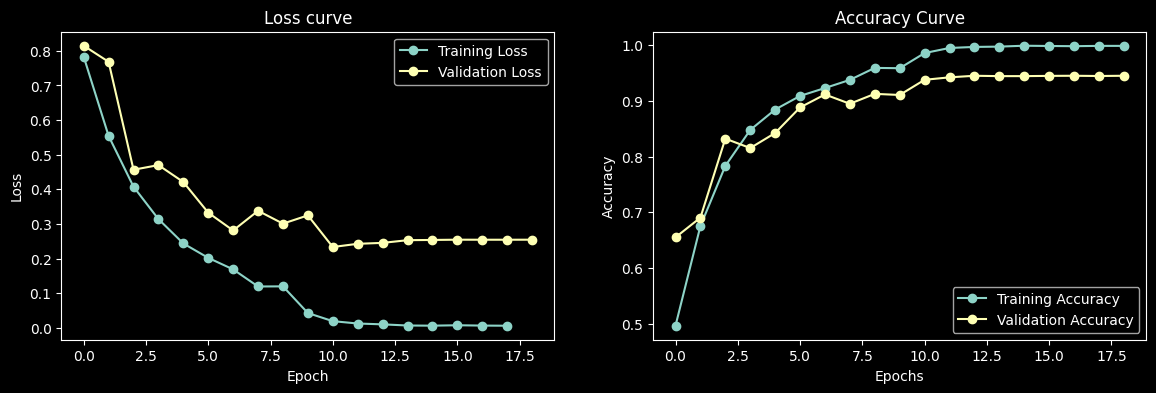

In [23]:
###summary of training metrics
fig = plt.figure(figsize=(14,4))

ax=fig.add_subplot(1,2,1)
ax.plot(train_history.history['loss'][1:], marker = 'o', linestyle='-',label='Training Loss')
ax.plot(train_history.history['val_loss'], marker = 'o', linestyle='-',label='Validation Loss')
ax.legend()
ax.set_title("Loss curve")
ax.set_ylabel("Loss")
ax.set_xlabel('Epoch')

ax=fig.add_subplot(1,2,2)
ax.plot(train_history.history['accuracy'], marker = 'o', linestyle='-', label='Training Accuracy')
ax.plot(train_history.history['val_accuracy'], marker = 'o', linestyle='-',label='Validation Accuracy')
ax.set_title('Accuracy Curve')
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.legend()
#plt.show()

102/102 ━━━━━━━━━━━━━━━━━━━━ 29s 281ms/step - accuracy: 0.9354 - f1_score: 0.9372 - loss: 0.2815
Test Loss: 0.2949
Test Accuracy: 0.9380
Test f1_score glioma: 0.9195886254310608
Test f1_score meningioma: 0.9233192205429077
Test f1_score no_tumor: 0.9404696822166443
Test f1_score pituitary: 0.9720357060432434


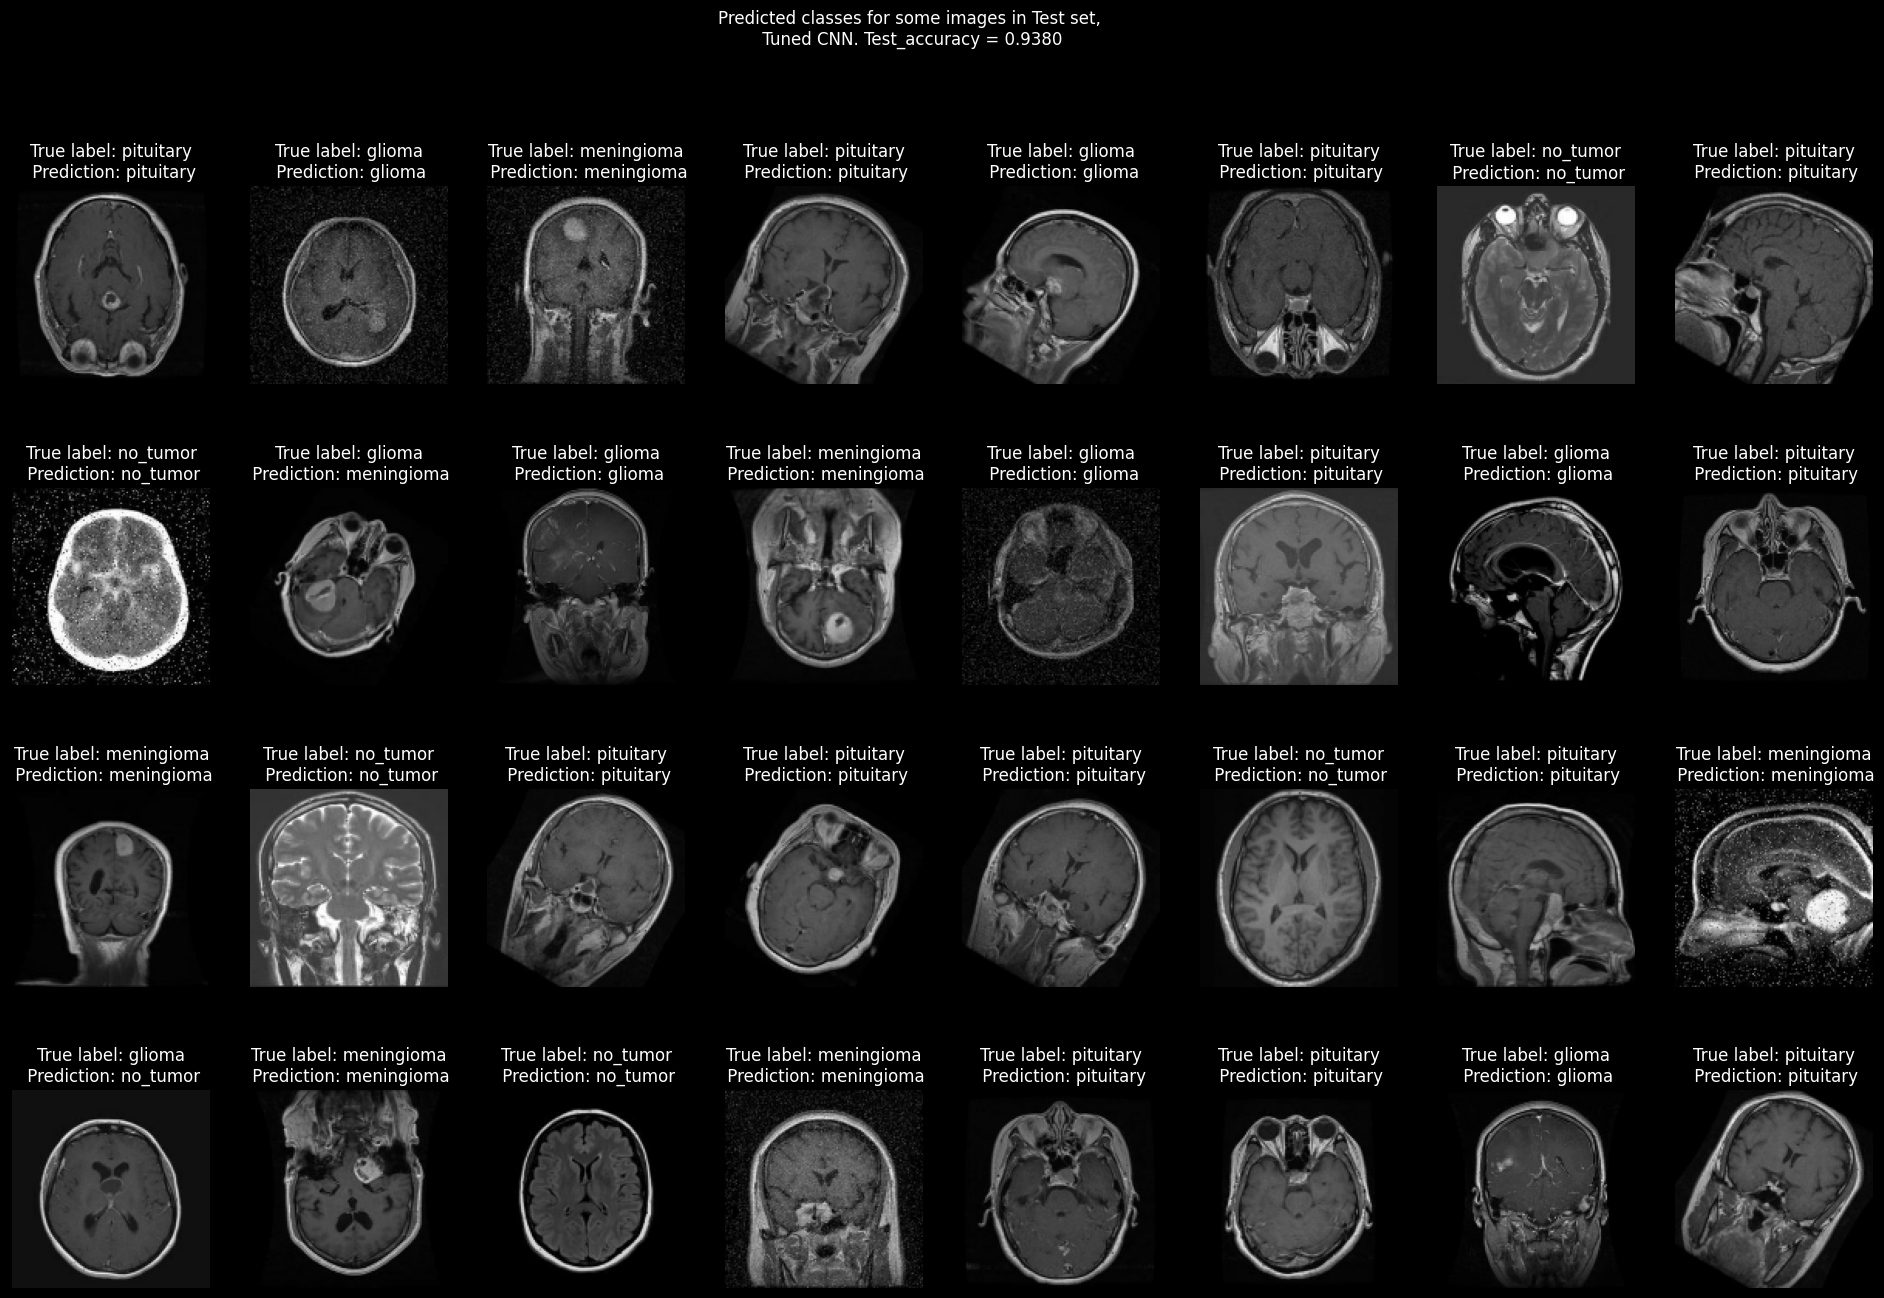

In [24]:
###Predictions
test_loss, test_accuracy, test_fscore =best_cnn.evaluate(test_generator)#, steps=test_generator.samples // test_generator.batch_size)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
for i, name in enumerate(class_names):
    print(f'Test f1_score {name}: {test_fscore[i]}')


test_batch = test_generator.take(1)
plt.figure(figsize=(24,15))
plt.suptitle(f'Predicted classes for some images in Test set, \n Tuned CNN. Test_accuracy = {test_accuracy:.4f} ')
for img, lbl in test_batch:
    for i in np.arange(32):###batch needs to have at least number of images to plot
        plt.subplot(4,8, i+1)
        plt.imshow(img[i].numpy().astype('uint8'))
        pred = best_cnn.predict(np.asarray(img[i]).reshape(1,img_rows, img_cols,3), verbose=0)
        pred_idx = np.argmax(pred)
        lbl_idx = np.argmax(lbl[i])
        plt.title(f'True label: {class_names[pred_idx]}\n Prediction: { class_names[lbl_idx]}' )
        plt.axis('off')

### B. MobileNet

In [15]:
### loading the model
mobilenet = tf.keras.applications.mobilenet.MobileNet(input_shape=(img_rows,img_cols,3), include_top = False, weights = 'imagenet')

for layer in mobilenet.layers:
    layer.trainable = False

In [16]:
def build_compile(basemodel):
    
    # flatten the output of the base model
    x = Flatten()(basemodel.output)
    # add a fully connected layer 
    x = Dense(512, activation='relu')(x)
    # add dropout layer for regularization
    x = Dropout(0.2)(x)
    # add final layer for classification
    x = Dense(4, activation='softmax')(x)

    model = Model(basemodel.input, x)
    model.compile(optimizer = Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy', 'f1_score'])
    model.summary()
    
    return model

custom_mobilenet= build_compile(mobilenet)

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 64, 64, 32)     │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 64, 64, 32)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 64, 64, 32)     │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 64, 64, 64)     │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 65, 65, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 32, 32, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 32, 32, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 32, 32, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 32, 32, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 11,620,036 (44.33 MB)

 Trainable params: 8,391,172 (32.01 MB)

 Non-trainable params: 3,228,864 (12.32 MB)

In [18]:
checkpoint_path='bt_customed_mobilenet_notune.keras'
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=6),
             tf.keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='loss', save_best_only=True, mode='min'),
             tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",factor=0.1,patience=3,verbose=1,mode="auto",
                                                  min_delta=0.001,cooldown=0,min_lr=0.0)
            ]

train_hist_mobilenet = custom_mobilenet.fit(train_generator, 
                                              epochs=n_epochs, 
                                              validation_data=validation_generator, 
                                              callbacks=callbacks)   

Epoch 1/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 91s 524ms/step - accuracy: 0.4979 - f1_score: 0.4791 - loss: 5.8768 - val_accuracy: 0.7431 - val_f1_score: 0.7336 - val_loss: 0.6135 - learning_rate: 0.0010
Epoch 2/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 93s 562ms/step - accuracy: 0.7550 - f1_score: 0.7558 - loss: 0.6020 - val_accuracy: 0.7771 - val_f1_score: 0.7807 - val_loss: 0.5810 - learning_rate: 0.0010
Epoch 3/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 93s 559ms/step - accuracy: 0.8066 - f1_score: 0.8090 - loss: 0.4746 - val_accuracy: 0.8189 - val_f1_score: 0.8213 - val_loss: 0.4794 - learning_rate: 0.0010
Epoch 4/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 95s 573ms/step - accuracy: 0.8493 - f1_score: 0.8539 - loss: 0.3839 - val_accuracy: 0.8277 - val_f1_score: 0.8306 - val_loss: 0.4508 - learning_rate: 0.0010
Epoch 5/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 102s 617ms/step - accuracy: 0.8739 - f1_score: 0.8776 - loss: 0.3221 - val_accuracy: 0.8369 - val_f1_score: 0.8389 - val_loss: 0.4354 - learning_rate: 0.0010
Epoch 6/50
166

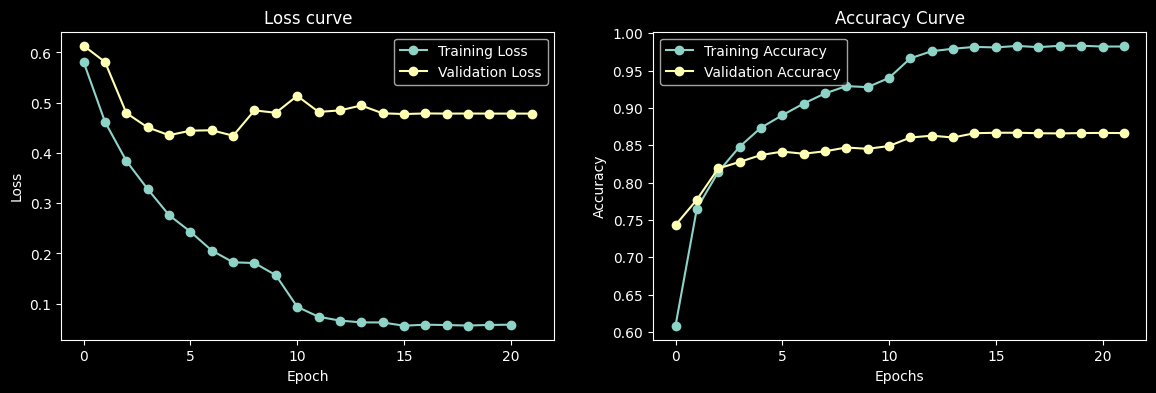

In [25]:
fig = plt.figure(figsize=(14,4))

ax=fig.add_subplot(1,2,1)
ax.plot(train_hist_mobilenet.history['loss'][1:], marker = 'o', linestyle='-',label='Training Loss')
ax.plot(train_hist_mobilenet.history['val_loss'], marker = 'o', linestyle='-',label='Validation Loss')
ax.legend()
ax.set_title("Loss curve")
ax.set_ylabel("Loss")
ax.set_xlabel('Epoch')

ax=fig.add_subplot(1,2,2)
ax.plot(train_hist_mobilenet.history['accuracy'], marker = 'o', linestyle='-', label='Training Accuracy')
ax.plot(train_hist_mobilenet.history['val_accuracy'], marker = 'o', linestyle='-',label='Validation Accuracy')
ax.set_title('Accuracy Curve')
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.legend()
#plt.show()

102/102 ━━━━━━━━━━━━━━━━━━━━ 33s 313ms/step - accuracy: 0.8623 - f1_score: 0.8662 - loss: 0.4762
Test Loss: 0.4767
Test Accuracy: 0.8607
Test f1_score glioma: 0.83535236120224
Test f1_score meningioma: 0.8018385767936707
Test f1_score no_tumor: 0.878606379032135
Test f1_score pituitary: 0.9406569004058838


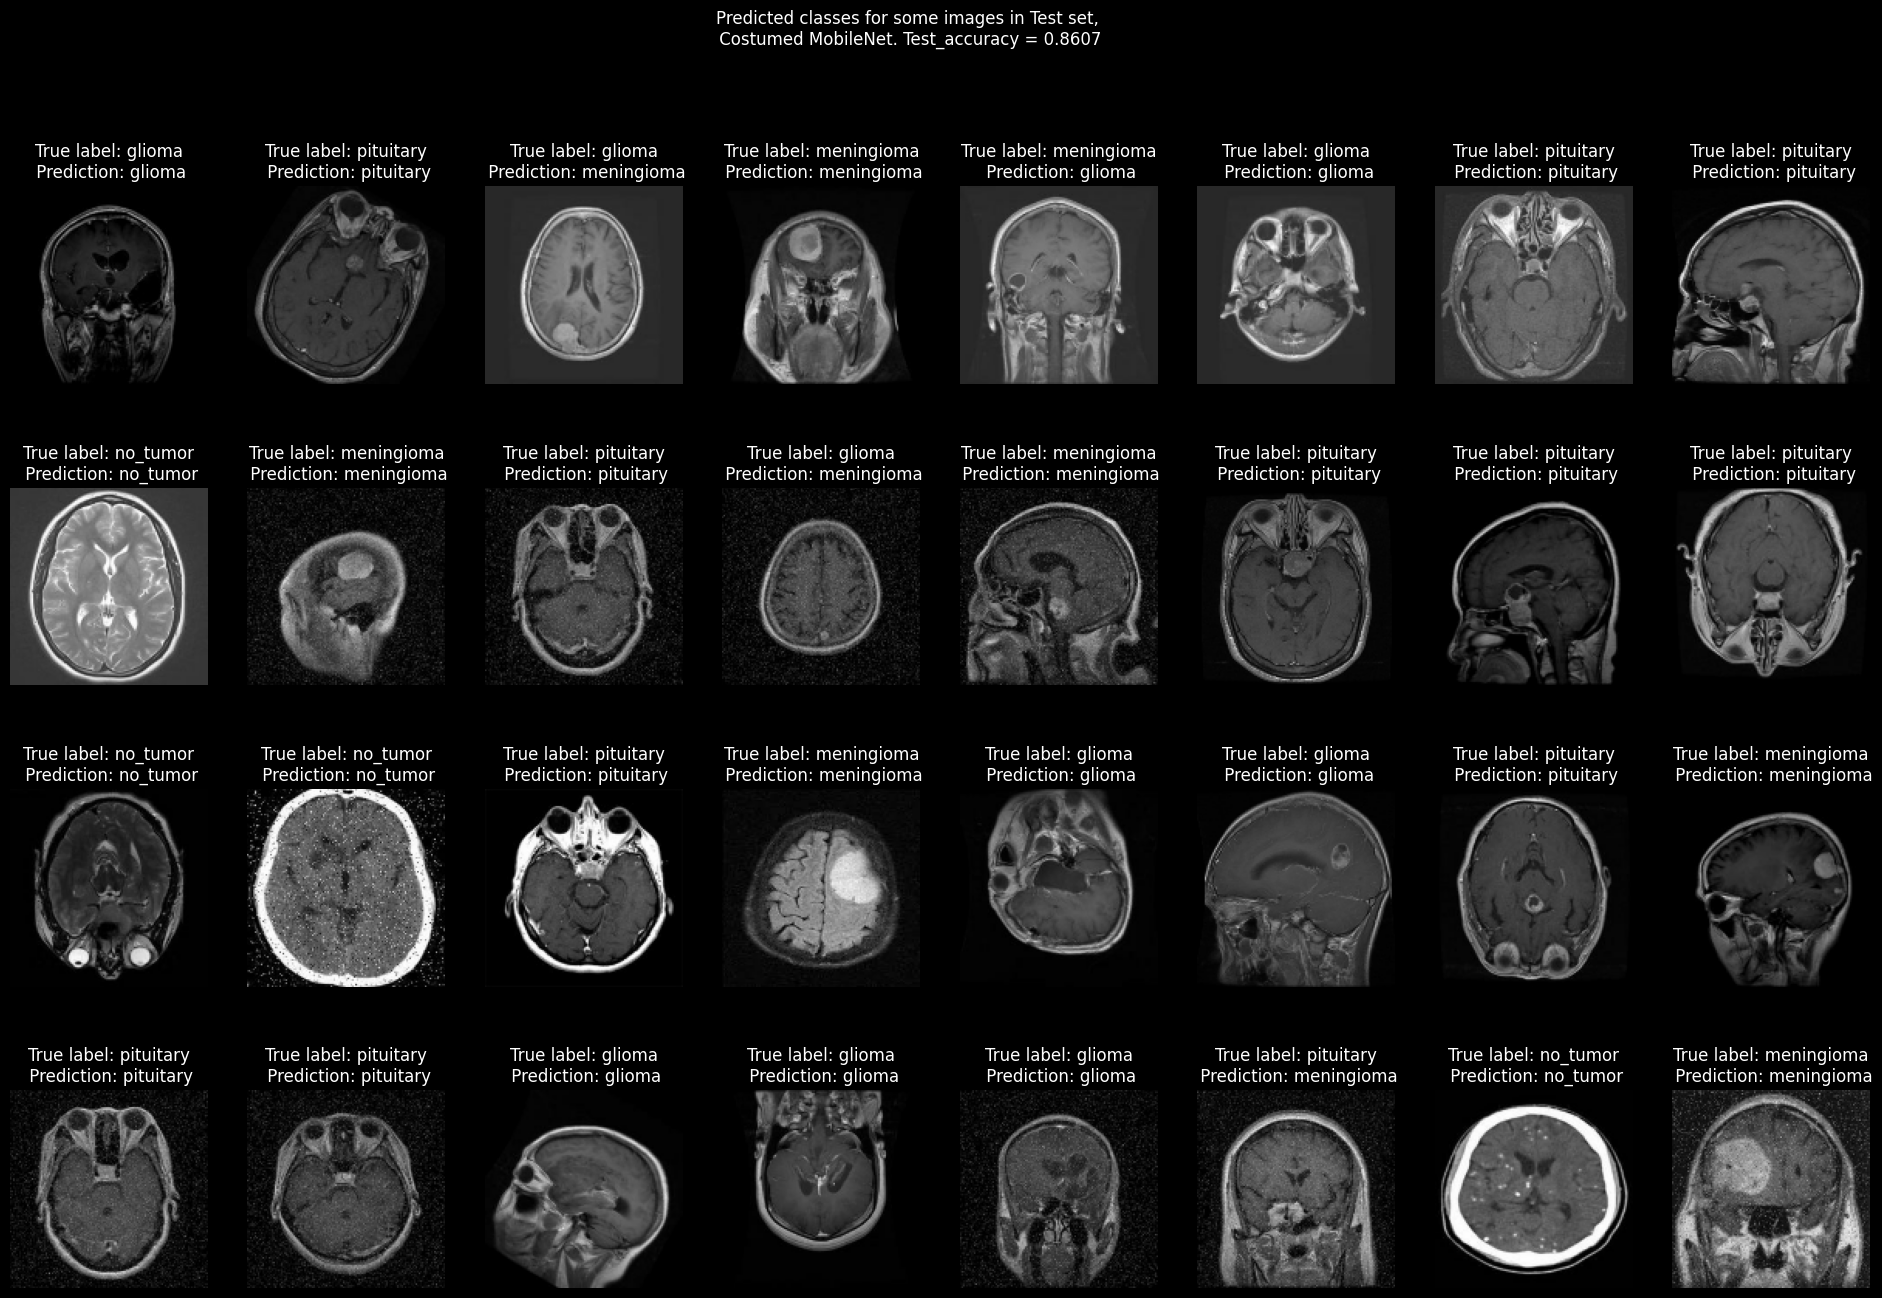

In [26]:
test_loss_mobile, test_accuracy_mobile, test_fscore_mobile =custom_mobilenet.evaluate(test_generator)#, steps=test_generator.samples // test_generator.batch_size)
print(f"Test Loss: {test_loss_mobile:.4f}")
print(f"Test Accuracy: {test_accuracy_mobile:.4f}")
for i, name in enumerate(class_names):
    print(f'Test f1_score {name}: {test_fscore_mobile[i]}')

plt.figure(figsize=(24,15))
plt.suptitle(f'Predicted classes for some images in Test set, \n Costumed MobileNet. Test_accuracy = {test_accuracy_mobile:.4f} ')
for img, lbl in test_batch:
    for i in np.arange(32):
        plt.subplot(4,8, i+1)
        plt.imshow(img[i].numpy().astype('uint8'))
        pred = custom_mobilenet.predict(np.asarray(img[i]).reshape(1,img_rows, img_cols,3), verbose=0)
        pred_idx = np.argmax(pred)
        lbl_idx = np.argmax(lbl[i])
        plt.title(f'True label: {class_names[pred_idx]}\n Prediction: { class_names[lbl_idx]}' )
        plt.axis('off')


## 5. Conclusion

In this notebook we considered a dataset containing (augmented) brain MRI scans divided into four classes: normal MRI scans, pituitary tumor, glioma tumor, and meningiome tumor. In the first part a Deep CNN (containing 4 hidden convolutional layers) was build and tuned. In the second part a pre-trained MobileNet network was used. 

The Deep CNN showed better performance reaching an accuracy of about $0.93$ on the test set (tha contains about 6500 augmented images).  This can be due to the lower size of training data (about 15000 images) and the small size of classes considered (only 4 classes). With a larger dataset and more labels to classify, a better approach could be to fine-tune a pretrained model. 